------------
# DTSA 5510 FINAL PROJECT
------------
Spam or Ham Text Detection with Natural Language Processing

Overview:
In this project, we are going to detect whether SMS messages are either Spam or Ham. We are going to use a tsv file that contains a collection of more than 5 thousand SMS phone messages. Using labeled ham and spam examples, we'll train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.

I am going to develop an SMS spam detector using SciKit Learn's Naive Bayes classifier algorithm. Before feeding data to Machine Learning NB algorithim, we need to process and clean each SMS with the help of Natural Language libraries.

Let's begin!





In [144]:
#Importing Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [145]:
#Data preprocessing
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from string import punctuation
from wordcloud import WordCloud

In [146]:
#Model imports
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

In [147]:
msgs=[line.rstrip() for line in open('SMSSpamCollection')]

In [148]:
print(len(msgs))

5574


In [149]:
msgs[10]

"ham\tI'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [150]:
for msg_num,msg in enumerate(msgs[:5]):
    print(msg_num,msg,'\n')
    

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... 

1 ham	Ok lar... Joking wif u oni... 

2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's 

3 ham	U dun say so early hor... U c already then say... 

4 ham	Nah I don't think he goes to usf, he lives around here though 



In [151]:
msgs[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [152]:
msgs=pd.read_csv('SMSSpamCollection', sep='\t', names=['label','message'])

In [153]:
msgs.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


------
# Exploratory Data Analysis (EDA)
------

In [154]:
msgs.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

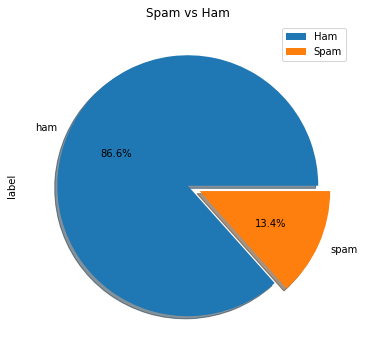

In [155]:
msgs["label"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [156]:
def binary_label(x):
    return 0 if x=='ham' else 1
msgs['Label_binary'] = msgs['label'].map(binary_label)
msgs.head()

,label,message,Label_binary
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [157]:
msgs['length']=msgs['message'].apply(len)
msgs.head()

,label,message,Label_binary,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


[Text(0.5, 1.0, 'Message length')]

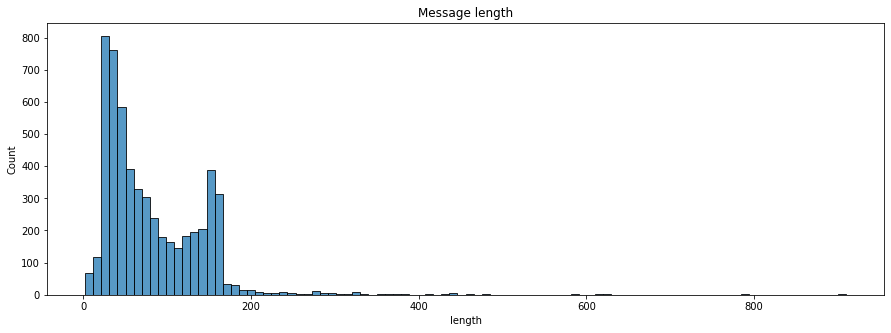

In [158]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.set_style=('Whitegrid')
sns.histplot(x='length',legend=False, data=msgs, palette="Set2").set(title='Message length')

In [159]:
msgs['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [160]:
#max message has 910 length. we need want to locate it
msgs[msgs['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

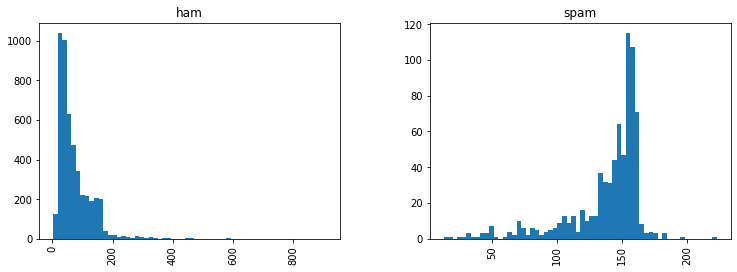

In [161]:
msgs.hist(column='length', by='label',bins=60, figsize=(12,4))

-------------
# Data Preprocessing 
-------------

Text preprocessing is a method to clean the text data and make it ready to feed data to the model. Text data contains noise in various forms like emotions, punctuation, text in a different case. This is an essential step in NLP as it is imperitive to make the text "readable" for the computer. We will first apply an autocorrect function the the messages column, then we will be employing the use of different cleaning techniques under one class function. They are listed below:

Removing numbers: Removing numbers from the text like “1,2,3,4,5…” We usually remove numbers when we do text clustering or getting keyphrases as we numbers doesn’t give much importance to get the main words.

Removing punctuation: Removing punctuation from the text like “.?!” and also the symbols like “@#$” 

Tokenization: 
Word tokenize-Tokenize words to get the tokens of the text i.e breaking the sentences into list of words.
Sentence tokenize-If the there are more than 1 sentence split it i.e breaking the sentences to a list of sentence.

Stop words removal: Remove irrelevant words using nltk stop words like “is,the,a” etc from the sentences as they don’t carry any information.

Stemming: Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma. Stemming is important in natural language processing (NLP).

Lemmatization: Lemmatization is similar to stemming but it brings context to the words.So it links words with similar meaning to one word.lemmatization does morphological analysis of the words. In short, lemmatize the text so as to get its root form eg: functions,funtionality as function

In [162]:
snowball_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

class Preprocess:
    def __int__(self, text):
        self.text=text
    
    def to_lower(self,text):
        """
        :param text:
        :return:
            Converted text to lower case as in, converting "Hello" to "hello" or "HELLO" to "hello".
        """
        return text.lower()

    def remove_numbers(self,text):
        """
        take string input and return a clean text without numbers.
        Use regex to discard the numbers.
        """
        return ''.join(c for c in text if not c.isdigit())

    def remove_punct(self,text):
        """
        take string input and clean string without punctuations.
        use regex to remove the punctuations.
        """
        return ''.join(c for c in text if c not in punctuation)

    def sentence_tokenize(self,text):
        """
        take string input and return list of sentences.
        use nltk.sent_tokenize() to split the sentences.
        """
        return list(nltk.sent_tokenize(text))

    def word_tokenize(self,text):
        """
        :param text:
        :return: list of words
        """
        return [w for sent in nltk.sent_tokenize(text) for w in nltk.word_tokenize(sent)]

    def remove_stopwords(self,sentence):
        """
        removes all the stop words like "is,the,a, etc."
        """
        stop_words = stopwords.words('english')
        return ' '.join([w for w in nltk.word_tokenize(sentence) if w not in stop_words])

    def stem(self,text):
        """
        :param word_tokens:
        :return: list of words
        """
        stemmed_word = [snowball_stemmer.stem(word) for sent in nltk.sent_tokenize(text)for word in nltk.word_tokenize(sent)]
        return " ".join(stemmed_word)

    def lemmatize(self,text):
        lemmatized_word = [wordnet_lemmatizer.lemmatize(word)for sent in nltk.sent_tokenize(text)for word in nltk.word_tokenize(sent)]
        return " ".join(lemmatized_word)


    def preprocess(self,text):
        lower_text = self.to_lower(text)
        sentence_tokens = self.sentence_tokenize(lower_text)
        word_list = []
        for each_sent in sentence_tokens:
            lemmatized_sent = self.lemmatize(each_sent)
            clean_text = self.remove_numbers(lemmatized_sent)
            clean_text = self.remove_punct(clean_text)
            clean_text = self.remove_stopwords(clean_text)
            word_tokens = self.word_tokenize(clean_text)
            word_list.extend(iter(word_tokens))
        return word_list


In [163]:
#Test case 
txt = msgs['message'][1]
pr = Preprocess()
print(pr.preprocess(txt))

['ok', 'lar', 'joking', 'wif', 'u', 'oni']


In [164]:
#Applying over entire column
msgs['message'] = msgs['message'].astype(str)
msgs['message'] = msgs.apply(lambda row: pr.preprocess(row["message"]), axis=1 )
msgs.head(10)

,label,message,Label_binary,length
0,ham,"[go, jurong, point, crazy, available, bugis, n...",0,111
1,ham,"[ok, lar, joking, wif, u, oni]",0,29
2,spam,"[free, entry, wkly, comp, win, fa, cup, final,...",1,155
3,ham,"[u, dun, say, early, hor, u, c, already, say]",0,49
4,ham,"[nah, nt, think, go, usf, life, around, though]",0,61
5,spam,"[freemsg, hey, darling, week, word, back, like...",1,147
6,ham,"[even, brother, like, speak, treat, like, aid,...",0,77
7,ham,"[per, request, melle, melle, oru, minnaminungi...",0,160
8,spam,"[winner, valued, network, customer, selected, ...",1,157
9,spam,"[mobile, month, u, r, entitled, update, latest...",1,154


In [165]:
spam_msgs = msgs[msgs["label"] == "spam"]["message"]
ham_msgs = msgs[msgs["label"] == "ham"]["message"]
print("No of spam messages : ",len(spam_msgs))
print("No of ham messages : ",len(ham_msgs))

No of spam messages :  747
No of ham messages :  4825


Wordcloud is a visualization technique for text data wherein each word is picturized with its importance in the context or its frequency.

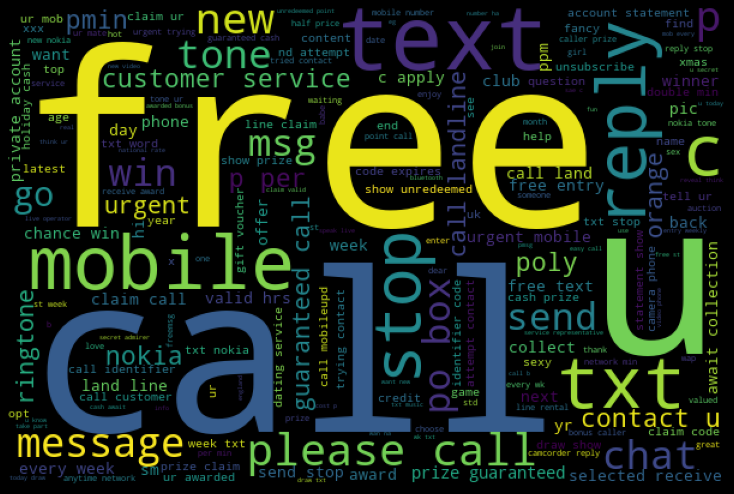

In [166]:
spam_wordcloud = WordCloud(width=600, height=400).generate(' '.join(' '.join(i) for i in spam_msgs))  
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

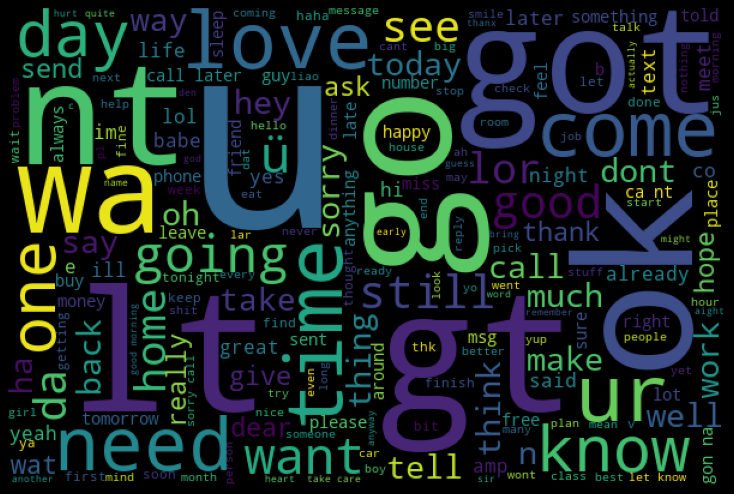

In [167]:
ham_wordcloud = WordCloud(width=600, height=400).generate(' '.join(' '.join(i) for i in ham_msgs))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [168]:
# Creating the Bag of Words

# Note that here we are passing already processed messages (after removing punctuations and stopwords)
msgs['message'] = msgs['message'].astype(str)
vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(msgs['message'])
print("20 Bag of Words (BOW) Features: \n")
print(vectorizer.get_feature_names_out()[20:40])

print("\nTotal number of vocab words : ",len(vectorizer.vocabulary_))


20 Bag of Words (BOW) Features: 

['absolutely' 'absolutly' 'abstract' 'abt' 'abta' 'aburo' 'abuse' 'abuser'
 'ac' 'academic' 'acc' 'accent' 'accenture' 'accept' 'access' 'accessible'
 'accidant' 'accident' 'accidentally' 'accommodation']

Total number of vocab words :  7550


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new bow_transformer:

In [169]:
test_txt = msgs['message'][3]
print(test_txt)

['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']


In [170]:
# fit_transform : Learn the vocabulary dictionary and return term-document matrix.
bow_test = bow_transformer.transform([test_txt])
print(bow_test)
print(bow_test.shape)

  (0, 196)	1
  (0, 1850)	1
  (0, 1870)	1
  (0, 2936)	1
  (0, 5530)	2
(1, 7550)


This means that there are seven unique words in message number 4 (after removing common stop words). Let's go ahead and check and confirm which ones appear twice:

In [171]:
print(bow_transformer.get_feature_names_out()[5530])

say


Now we can use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [172]:
msgs_bow = bow_transformer.transform(msgs['message'])

In [173]:
print('Shape of Sparse Matrix: ', msgs_bow.shape)
print('Amount of Non-Zero occurences: ', msgs_bow.nnz)

Shape of Sparse Matrix:  (5572, 7550)
Amount of Non-Zero occurences:  45401


---------
# TF-IDF
---------

TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t)=Number of times term t appears in a documentTotal number of terms in the document.
 
IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t)=loge(Total number of documentsNumber of documents with term t in it).
 
Let's do this in SciKit Learn.

In [174]:
tfidf_transformer = TfidfTransformer().fit(msgs_bow)

In [175]:

tfidf_test = tfidf_transformer.transform(bow_test)
print(tfidf_test)

  (0, 5530)	0.6009919413443975
  (0, 2936)	0.5240530099842268
  (0, 1870)	0.3785754532682489
  (0, 1850)	0.3487373449477656
  (0, 196)	0.31502383971231035


In [176]:
print(bow_transformer.get_feature_names_out()[5530])
print(bow_transformer.get_feature_names_out()[2936])

say
hor



We'll go ahead and check what is the IDF (inverse document frequency) of the "hor"?

In [177]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['hor']])

8.527076498901426


Let's transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [178]:
messages_tfidf = tfidf_transformer.transform(msgs_bow)
print(messages_tfidf.shape)

(5572, 7550)


Lets convert our clean text into a representation that a machine learning model can understand. I'll use the Tfidf for this

In [179]:
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(msgs["message"])
print(features.shape)

print(len(vec.vocabulary_))

(5572, 7384)
7384


# Train-Test split

In [180]:
from sklearn.model_selection import train_test_split


msg_train, msg_test, label_train, label_test = \
train_test_split(messages_tfidf, msgs['Label_binary'], test_size=0.2)

In [181]:
print("train dataset features size : ",msg_train.shape)
print("train dataset label size", label_train.shape)

print("\n")

print("test dataset features size", msg_test.shape)
print("test dataset lable size", label_test.shape)

train dataset features size :  (4457, 7550)
train dataset label size (4457,)


test dataset features size (1115, 7550)
test dataset lable size (1115,)


# Initializing Naive Bayes classifier Model

Let's create a Naive Bayes classifier Model using Scikit-learn.

In [182]:
clf = MultinomialNB()
spam_detect_model = clf.fit(msg_train, label_train)

In [183]:
predict_train = spam_detect_model.predict(msg_train)

In [184]:
print("Classification Report \n",metrics.classification_report(label_train, predict_train))
print("\n")
print("Confusion Matrix \n",metrics.confusion_matrix(label_train, predict_train))
print("\n")
print("Accuracy of Train dataset : {0:0.3f}".format(metrics.accuracy_score(label_train, predict_train)))

Classification Report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      3859
           1       1.00      0.79      0.88       598

    accuracy                           0.97      4457
   macro avg       0.98      0.89      0.93      4457
weighted avg       0.97      0.97      0.97      4457



Confusion Matrix 
 [[3859    0]
 [ 126  472]]


Accuracy of Train dataset : 0.972


In [185]:
#predicting the over the entire dataset (0 = ham, 1 = spam)

label_predictions = spam_detect_model.predict(msg_test)
print(label_predictions)

[0 0 0 ... 0 0 0]


In [186]:
print(metrics.classification_report(label_test, label_predictions))
print(metrics.confusion_matrix(label_test, label_predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.78      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

[[966   0]
 [ 33 116]]


In [187]:
# Printing the Overall Accuracy of the model
print("Accuracy of the model : {0:0.3f}".format(metrics.accuracy_score(label_test, label_predictions)))

Accuracy of the model : 0.970


-------------
# Conclusion
-------------

The Model did very well with it's predictions, giving a 97.2% training accuracy and a 97% testing accuracy. One way to improve on the model would be to add more features to the preprocessing class, such as autocorrecting the short text in the SMS messages which would give a more accurate prediction outcome.



------------
# References
------------
3.1. cross-validation: Evaluating estimator performance. scikit. (n.d.). Retrieved October 5, 2022, from https://scikit-learn.org/stable/modules/cross_validation.html 

Goyal, C. (2021, June 26). Topic modelling using NMF: Guide to master NLP (part 14). Analytics Vidhya. Retrieved October 5, 2022, from https://www.analyticsvidhya.com/blog/2021/06/part-15-step-by-step-guide-to-master-nlp-topic-modelling-using-nmf/ 

pemagrg1. (n.d.). PEMAGRG1/text-pre-processing-in-python: Text pre-processing text in&nbsp;python. created date: 31 Oct 2018. GitHub. Retrieved October 5, 2022, from https://github.com/pemagrg1/Text-Pre-Processing-in-Python 

Topics extraction with non-negative matrix factorization¶. scikit. (n.d.). Retrieved October 5, 2022, from https://scikit-learn.org/0.15/auto_examples/applications/topics_extraction_with_nmf.html 